In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 as cv
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_dataset_Summary.csv
/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1676_virus_2892.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/NORMAL2-IM-0336-0001.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person1650_virus_2852.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person22_virus_55.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/IM-0101-0001.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/person122_bacteria_582.jpeg
/kaggle/input/coronahack-chest-xraydataset/Coron

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

In [4]:
df_meta=pd.read_csv("/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv",index_col=0)
df_meta.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


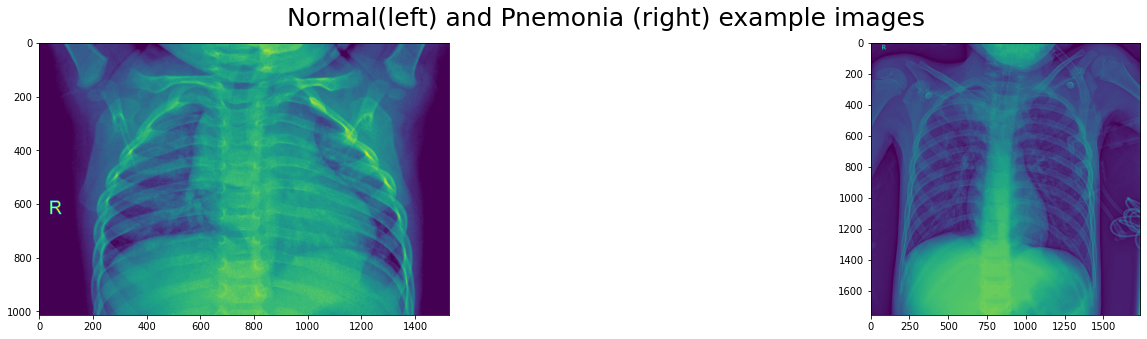

In [5]:
normal=df_meta[df_meta["Label"]=="Normal"].iloc[0]
pnemonia=df_meta[df_meta["Label"]=="Pnemonia"].iloc[0]
plt.figure(figsize=(25,5))
plt.suptitle(" Normal(left) and Pnemonia (right) example images", fontsize="25")
plt.subplot(121)
plt.imshow(plt.imread("/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"+
                      normal["Dataset_type"].lower()+"/"+normal["X_ray_image_name"]))

plt.subplot(122)
plt.imshow(plt.imread("/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"+
                      pnemonia["Dataset_type"].lower()+"/"+pnemonia["X_ray_image_name"]))

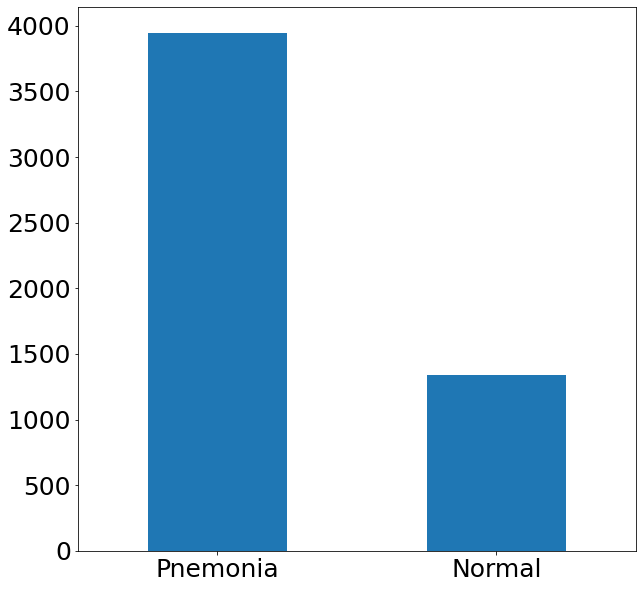

In [6]:
plt.figure(figsize=(10,10))
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts().plot.bar(rot=0)
plt.tick_params(labelsize=25)

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,
zoom_range=0.1,
brightness_range=[0.5,1.3],
width_shift_range=0.1,
height_shift_range=0.1,
validation_split=0.1)


test_datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input,
zoom_range=0.1,
brightness_range=[0.5,1.3],
width_shift_range=0.1,
height_shift_range=0.1,
validation_split=0.1)

In [32]:
BATCH_SIZE=8
path="../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/"

train_images=train_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TRAIN"],
x_col='X_ray_image_name',
y_col='Label',
color_mode='rgb',
class_mode='categorical',
target_size=(150,150),
batch_size=BATCH_SIZE,
shuffle=True,seed=1234,
subset='training',
directory=path+"/train")

val_images=train_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TRAIN"],
x_col='X_ray_image_name',
y_col='Label',
color_mode='rgb',
class_mode='categorical',
target_size=(150,150),
batch_size=BATCH_SIZE,
shuffle=True,
seed=1234,subset='validation', 
directory=path+"/train")

test_images = test_datagen.flow_from_dataframe(dataframe=df_meta[df_meta["Dataset_type"]=="TEST"],
x_col='X_ray_image_name',
y_col='Label',
color_mode='rgb',
class_mode='categorical',
target_size=(150,150),
batch_size=BATCH_SIZE,
shuffle=False, 
directory=path+"/test")

Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [9]:
normal=df_meta[df_meta["Label"]=="Normal"].iloc[0]
pnemonia=df_meta[df_meta["Label"]=="Pnemonia"].iloc[0]


In [10]:
normal

X_ray_image_name          IM-0128-0001.jpeg
Label                                Normal
Dataset_type                          TRAIN
Label_2_Virus_category                  NaN
Label_1_Virus_category                  NaN
Name: 0, dtype: object

In [11]:
dataframe=df_meta[df_meta["Dataset_type"]=="TRAIN"]

In [14]:
inputs = tf.keras.layers.Input((150,150,3))
base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='avg') 
x=base_model(inputs)
output=layers.Dense(2, activation='sigmoid')(x)
model=tf.keras.models.Model(inputs=inputs, outputs=output)

2022-12-17 11:44:50.067951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 11:44:50.068938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 11:44:50.331550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 11:44:50.332574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 11:44:50.333463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

83697664/83683744 [==============================] - 1s 0us/step


In [34]:
model.compile(Adamax(learning_rate=1e-4), loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_images,validation_data=val_images, epochs=8)

Epoch 1/8
595/595 [==============================] - 119s 193ms/step - loss: 0.0550 - accuracy: 0.9815 - val_loss: 1.5360 - val_accuracy: 0.8883
Epoch 2/8
595/595 [==============================] - 112s 188ms/step - loss: 0.0385 - accuracy: 0.9872 - val_loss: 0.6800 - val_accuracy: 0.9508
Epoch 3/8
595/595 [==============================] - 110s 184ms/step - loss: 0.0383 - accuracy: 0.9857 - val_loss: 2.8058 - val_accuracy: 0.9261
Epoch 4/8
595/595 [==============================] - 111s 187ms/step - loss: 0.0324 - accuracy: 0.9916 - val_loss: 1.6109 - val_accuracy: 0.9261
Epoch 5/8
595/595 [==============================] - 111s 187ms/step - loss: 0.0272 - accuracy: 0.9916 - val_loss: 3.5282 - val_accuracy: 0.9148
Epoch 6/8
595/595 [==============================] - 111s 186ms/step - loss: 0.0255 - accuracy: 0.9914 - val_loss: 5.1428 - val_accuracy: 0.9034
Epoch 7/8
595/595 [==============================] - 110s 185ms/step - loss: 0.0252 - accuracy: 0.9908 - val_loss: 2.0492 - val_ac

In [35]:


preds=model.predict(test_images)
preds = np.argmax(preds,axis=1)
preds=preds>0.5
gt=[0 if x=="Normal" else 1 for x in df_meta[df_meta["Dataset_type"]=="TEST"]["Label"]]
print("Results on test set:")
print(classification_report(gt,preds,target_names=["Normal","Phemonia"]))

Results on test set:
              precision    recall  f1-score   support

      Normal       0.97      0.72      0.83       234
    Phemonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



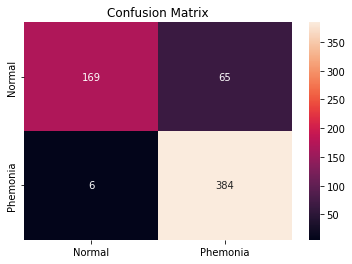

In [36]:
conf_matrix = confusion_matrix(gt, preds)
sns.heatmap(conf_matrix,xticklabels = ["Normal","Phemonia"], yticklabels =["Normal","Phemonia"],annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.show()